# Example of modular usage

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib import colors

from astropy.coordinates import SkyCoord
from astropy import units as u

from datetime import datetime
now = datetime.now().strftime("%y%m%d-%H%M%S")
hour = datetime.now().strftime("%y%m%d-%H")
today = datetime.now().strftime("%y%m%d")

from bowshockpy import NarrowJet
from bowshockpy.models import ObsModel
from bowshockpy import utils as ut
from bowshockpy import moments
from bowshockpy import __version__

# TODO erease these lines
%load_ext autoreload
%autoreload 2

In [2]:
__version__

'0.2.0'

In [3]:
bs.ObsModel?

Object `bs.ObsModel` not found.


In [535]:
distpc = 300

# name of the model
modelname =  f"example_{now}"

# Characteristic lenght scale of the bowshock [km] 
# L0 = (0.591 * distpc * u.au).to(u.km).value
L0 = (0.391 * distpc * u.au).to(u.km).value

# distance from the source to the internal working surface [km]
zj = (4.58 * distpc * u.au).to(u.km).value 

# velocity of the internal working surface [km/s]
vj = 111.5                                    

# velocty of the ambient [km/s]
va = 0                                      

# velocity at which the material is ejected sideways [km/s]
# v0 = 22.9                                    
v0 = 15

# total mass of the bowshock shell [Msun]
mass = 0.000231                               

# final radius of the bowhsock [km]
rbf_obs = (0.75 * distpc * u.au).to(u.km).value


In [536]:
bowshock_model = NarrowJet(
    L0=L0, zj=zj, vj=vj,
    va=va, v0=v0, mass=mass,
    rbf_obs=rbf_obs, distpc=distpc,
    )

In [ ]:
class BowshockModelPlot():
    """
    Figure including the main parameters of the bowshock model, its morphology
    and kinematics, and the distribution of the surface density
    
    Parameters:
    -----------
    bsm : `~bowshockpy.models.NarrowJet` class instance
        Instance of the model to plot
    modelname : optional, str
        Name of the model to include in the plot
    nzs : optional, int
        Number of points used to compute the model solutions
    figsize: optional, tuple
        Tuple passed to `matplotib.pyplot.figure` to define the dimensions of
        the figure
    narrows: optional, int
        Number of arrows to show in order to indicate the velocity at each
        symmetrical half of the model.        
    v_arrow_ref: optional, float
        Velocity in km/s to use as reference in the reference arrow
    linespacing : optional, float
        Spacing between the text lines
    textbox_widthratio : optional, float
        Width ratio of the text ax to pass to GridSpec

    Attributes:
    -----------
    nzs : int
        Number of points used to compute the model solutions
    zs : numpy.ndarray
        Array of the z-coordinates of the model.
    dzs : numpy.ndarray
        Increment of z-coordinates between the points.
    Rs : numpy.ndarray
        Array with the radii of the model at each z-coordinate [km].
    thetas : numpy.ndarray
        Array of the polar angle of the position vector at each point of the
        model [radians].
    vs : numpy.ndarray
        Array of the total velocity for each point of the model [km/s].
    vrs : numpy.ndarray
        Array of the radial component of the velocity at each point of the model
        [km/s].
    vzs : numpy.ndarray
        Array of the z-coordinate component of the velocity at each point of the
        model [km/s].
    surfdenss : numpy.ndarray 
        Array of the surfance density of the shell at each z-coordinate [Msun
        km-2]
    surfdenss_gcm2 : numpy.ndarray
        Array of the surfance density of the shell at each z-coordinate [g cm-2]
    axs : dict
        Dictionary of matplotlib.axes.Axes in the figure
    cbaxs : dict
        Dictionary of matplotlib.axes.Axes of the colorbars in the figure
    """

    def __init__(
            self, bsm, modelname="none", nzs=200,
            figsize=(16,3), narrows=10, v_arrow_ref=100,
            linespacing=0.08, textbox_widthratio=0.7,
            ):
        self.mo = bsm
        self.modelname = modelname
        self.nzs = nzs
        self.nrs = nzs
        self.narrows = narrows 
        self.figsize = figsize
        self.v_arrow_ref = v_arrow_ref
        self.linespacing = linespacing
        self.textbox_widthratio = textbox_widthratio

        self.zs = np.array([])
        self.dzs = np.array([])
        self.Rs = np.array([])

        self.vrs = np.array([])
        self.vzs = np.array([])
        self.vs = np.array([])
        self.thetas = np.array([])
        self.Rs_arcsec = np.array([])
        self.zs_arcsec = np.array([])

        self.surfdenss = np.array([])
        self.surfdenss_gcm2 = np.array([])

        self.zs_arrows = np.array([])
        self.Rs_arrows = np.array([])
        self.zs_arrows_tip = np.array([])
        self.Rs_arrows_tip = np.array([])
        self.z_arrow_ref_tip = None
        self.R_arrow_ref_tip = None

        self.axs = {}
        self.cbaxs = {}
        self.maxsurfdens_plot = None
        self.minsurfdens_plot = None

        self._calc_solutions()
        self._calc_arrows()
        # self._create_axes()
        # self.plot()

    def _calc_solutions(self):
        # self.zsextended = self.zb_r(
        #     np.linspace(self.rbf, self.rj, self.nzs)
        # )
        # self.nrs = self.nzs
        self.rs = np.linspace(self.mo.rbf, 0, self.nrs)
        self.dr = self.rs[0] - self.rs[1]
        self.zs = self.mo.zb_r(self.rs)
        self.dzs = self.mo.dz_func(self.mo.zb_r(self.rs), self.dr)

        self.vs = np.array([self.mo.vtot(zb) for zb in self.zs])
        self.Rs = np.array([self.mo.rb(zb) for zb in self.zs])
        self.vrs = np.array([self.mo.vr(zb) for zb in self.zs])
        self.vzs = np.array([self.mo.vz(zb) for zb in self.zs])
        self.vs = np.array([np.sqrt(vrr**2+vzz**2) for vrr, vzz in zip(self.vrs, self.vzs)])
        self.maxvs = np.max(self.vs)
        self.minvs = np.min(self.vs)
        self.thetas = np.array([np.arctan(self.Rs[i] / z)
                       for i, z in enumerate(self.zs)])

        self.Rs_arcsec = self.mo.km2arcsec(self.Rs)
        self.zs_arcsec = self.mo.km2arcsec(self.zs)
 
        self.surfdenss = np.array([self.mo.surfdens(zb) for zb in self.zs])
        self.surfdenss_gcm2 = self.mo.solMasskm2togcm2(self.surfdenss)

    def _calc_arrows(self):
        idx_arr = int(len(self.zs_arcsec)/self.narrows)
        self.larrow = 1 / np.max([np.max(self.vrs), np.max(self.vzs)])

        self.zs_arrows = self.zs_arcsec[::idx_arr]
        self.Rs_arrows = self.Rs_arcsec[::idx_arr]

        self.zs_arrows_tip = self.zs_arrows + self.larrow * self.vzs[::idx_arr]
        self.Rs_arrows_tip = self.Rs_arrows + self.larrow * self.vrs[::idx_arr]

    def _create_axes(self):
        nrow = 1
        ncol = 3
        wspace = 0.2
        hspace = 0.4
        width_ratios = [self.textbox_widthratio, 1, 1]
        height_ratios = [1] * nrow

        self.fig_model = plt.figure(figsize=self.figsize)
        gs = GridSpec(
            nrow, ncol,
            height_ratios=height_ratios,
            width_ratios=width_ratios,
            hspace=hspace, wspace=wspace
        )
        gss = {}
        gss[0] = gs[0, 1].subgridspec(
            2, 1,
            height_ratios=[0.05, 1],
            width_ratios=[1],
            hspace=0.05,
        )
        gss[1] = gs[0, 2].subgridspec(
            2, 1,
            height_ratios=[0.05, 1],
            width_ratios=[1],
            hspace=0.05,
        )
        # gss[2] = gs[1, 1].subgridspec(
        #     2, 1,
        #     height_ratios=[0.05, 1],
        #     width_ratios=[1],
        #     hspace=0.05,
        # )

        self.axs["text"] = plt.subplot(gs[:, 0])
        self.axs[0] = plt.subplot(gss[0][1, 0])
        self.cbaxs[0] = plt.subplot(gss[0][0, 0])
        self.axs[1] = plt.subplot(gss[1][1, 0])
        self.cbaxs[1] = plt.subplot(gss[1][0, 0])
        self.axs["text"].set_axis_off()

    def plot(self):
        """
        Plots the 2D bowshock model
        """
        self._create_axes()
        showtext = \
            fr"""
            {self.modelname}

            $v_\mathrm{{j}} = {{{self.mo.vj:.2f}}}$ km/s
            $v_0 = {{{self.mo.v0:.2f}}}$ km/s
            $v_a = {{{self.mo.va:.2f}}}$ km/s
            $L_0 = {{{self.mo.L0_arcsec:.2f}}}$ arcsec
            $z_\mathrm{{j}} = {{{self.mo.zj_arcsec:.2f}}}$ arcsec
            $r_\mathrm{{b,f}} = {{{self.mo.rbf_arcsec:.2f}}}$ arcsec
            $t_\mathrm{{j}} = {{{self.mo.tj_yr:.2f}}}$ yr
            $\rho_a = {{{self.mo.rhoa_gcm3*10**20:.2f}}}\times 10^{{-20}}$ g cm$^{{-3}}$
            $\dot{{m}}_0 = {{{self.mo.mp0_solmassyr*10**6:.2f}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
            $\dot{{m}}_{{a,f}} = {{{self.mo.mpamb_f_solmassyr*10**6:.2f}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
            """

        self.axs["text"].set_axis_off()
        for n, line in enumerate(showtext.split("\n")):
             self.axs["text"].text(0, 1.05-self.linespacing*n, line, fontsize=10,
                              transform=self.axs["text"].transAxes)

        """
        Deprojected shell Morph. and Kin., color velocity
        """
        cmap = "turbo_r"
        for i, zarcsec in enumerate(self.zs_arcsec):
            c = ut.get_color(
                [self.minvs, self.maxvs],
                self.vs[i],
                cmap,
            )
            self.axs[0].plot(
                zarcsec,
                self.Rs_arcsec[i],
                color=c,
                marker="o",
            )
            self.axs[0].plot(
                zarcsec,
                -self.Rs_arcsec[i],
                color=c,
                marker="o",
            )
        cbar = plt.colorbar(
               cm.ScalarMappable(
                   norm=colors.Normalize(
                       vmax=self.maxvs,
                       vmin=self.minvs),
                   cmap=cmap,
               ),
               cax=self.cbaxs[0],
               orientation="horizontal",
        )

        for i in range(len(self.zs_arrows)):
            self.axs[0].annotate(
                "",
                xy=(self.zs_arrows_tip[i], self.Rs_arrows_tip[i]),
                xytext=(self.zs_arrows[i], self.Rs_arrows[i]),
                arrowprops=dict(arrowstyle="->"))
            self.axs[0].annotate(
                "",
                xy=(self.zs_arrows_tip[i], -self.Rs_arrows_tip[i]),
                xytext=(self.zs_arrows[i], -self.Rs_arrows[i]),
                arrowprops=dict(arrowstyle="->"))

        xlims = [np.min(self.zs_arcsec),
                np.max(np.max(self.zs_arrows_tip))*1.1]
        ylims = [-np.max(self.Rs_arcsec)*1.3, np.max(self.Rs_arcsec)*1.3]
        self.axs[0].set_xlim(xlims)
        self.axs[0].set_ylim(ylims)
        larrow_scaled = self.larrow * self.v_arrow_ref
        self.z_arrow_ref = xlims[1]*0.97 - larrow_scaled
        self.R_arrow_ref = ylims[0] + np.diff(ylims)*0.05
        self.z_arrow_ref_tip = self.z_arrow_ref + larrow_scaled 
        self.R_arrow_ref_tip = self.R_arrow_ref + self.larrow * 0
        self.axs[0].annotate(
            "",
            xy=(self.z_arrow_ref_tip, self.R_arrow_ref_tip),
            xytext=(self.z_arrow_ref, self.R_arrow_ref),
            arrowprops=dict(arrowstyle="->"))

        self.axs[0].text(
            self.z_arrow_ref+0.0,
            self.R_arrow_ref+0.05,
            f"{self.v_arrow_ref:d} km/s"
        )

        self.axs[0].set_aspect("equal")
        self.axs[0].set_xlabel("Distance [arcsec]")
        self.axs[0].set_ylabel("Radius [arcsec]")

        self.cbaxs[0].tick_params(
            bottom=False, labelbottom=False,
            top=True, labeltop=True
        )
        self.cbaxs[0].set_xlabel(r"Speed [km/s]", )
        self.cbaxs[0].xaxis.set_label_position('top')


        """
        Deprojected shell Morph. and Kin., color density
        """
        self.minsurfdens_plot = np.percentile(self.surfdenss_gcm2[:-1], 0) 
        self.maxsurfdens_plot = np.percentile(self.surfdenss_gcm2[:-1], 70)
        norm = colors.LogNorm(
                    vmax=self.maxsurfdens_plot,
                    vmin=self.minsurfdens_plot,
        #           linthresh=self.maxsurfdens*0.99,
                    )
        cmap = "viridis"
        # we skip the point at the tip, there is a discontinuity and the surface
        # density is 0
        for i, zarcsec in enumerate(self.zs_arcsec[:-1]):
            c = ut.get_color(
                [self.minsurfdens_plot, self.maxsurfdens_plot],
                self.surfdenss_gcm2[i],
                cmap,
                customnorm=norm, 
            )
            self.axs[1].plot(
                zarcsec,
                self.Rs_arcsec[i],
                color=c,
                marker="o",
            )
            self.axs[1].plot(
                zarcsec,
                -self.Rs_arcsec[i],
                color=c,
                marker="o",
            )
        cbar = plt.colorbar(
               cm.ScalarMappable(
                   norm=norm,
                   cmap=cmap,
               ),
               cax=self.cbaxs[1],
               orientation="horizontal",
        )
        self.cbaxs[1].tick_params(
            axis="x", which="both", top=True, bottom=False
        )
#        self.cbaxs[1].set_xscale("log")

        for i in range(len(self.zs_arrows)):
            self.axs[1].annotate(
                "",
                xy=(self.zs_arrows_tip[i], self.Rs_arrows_tip[i]),
                xytext=(self.zs_arrows[i], self.Rs_arrows[i]),
                arrowprops=dict(arrowstyle="->"))
            self.axs[1].annotate(
                "",
                xy=(self.zs_arrows_tip[i], -self.Rs_arrows_tip[i]),
                xytext=(self.zs_arrows[i], -self.Rs_arrows[i]),
                arrowprops=dict(arrowstyle="->"))

        xlims = [np.min(self.zs_arcsec),
                np.max(np.max(self.zs_arrows_tip))*1.1]
        ylims = [-np.max(self.Rs_arcsec)*1.3, np.max(self.Rs_arcsec)*1.3]
        self.axs[1].set_xlim(xlims)
        self.axs[1].set_ylim(ylims)
        larrow_scaled = self.larrow * self.v_arrow_ref
        self.z_arrow_ref = xlims[1]*0.97 - larrow_scaled
        self.R_arrow_ref = ylims[0] + np.diff(ylims)*0.05
        self.z_arrow_ref_tip = self.z_arrow_ref + larrow_scaled 
        self.R_arrow_ref_tip = self.R_arrow_ref + self.larrow * 0
        self.axs[1].annotate(
            "",
            xy=(self.z_arrow_ref_tip, self.R_arrow_ref_tip),
            xytext=(self.z_arrow_ref, self.R_arrow_ref),
            arrowprops=dict(arrowstyle="->"))

        self.axs[1].text(
            self.z_arrow_ref+0.0,
            self.R_arrow_ref+0.05,
            f"{self.v_arrow_ref:d} km/s"
        )

        self.axs[1].set_aspect("equal")
        self.axs[1].set_xlabel("Distance [arcsec]")
        #self.axs[1].set_ylabel("Radius [arcsec]")

        self.cbaxs[1].set_xlabel(r"Surface density [g cm$^{-2}$]", )
        self.cbaxs[1].xaxis.set_label_position('top')
        self.cbaxs[1].tick_params(
            axis="x",
             bottom=False, labelbottom=False,
             top=True, labeltop=True
         )
        # For some reason tick_params is not able to plot the ticks above if the
        # tick lables are in scientific notation. I have to do:
        self.cbaxs[1].xaxis.set_ticks_position('top')
        self.cbaxs[1].xaxis.set_label_position('top') 

    def savefig(self, figname=None):
        """
        Saves the plot of the bowhsock model.       

        Parameters
        ----------
        figname : optional, str
            Full path name of the figure. If None, the the full path name will
            be models/{self.modelname}/bowshock_plot.pdf. If the folder tree does not exist, it will be created. 
        """
        if figname is None:
            ut.make_folder(f"models/{self.modelname}")
            figname = f"models/{self.modelname}/bowshock_plot.pdf"
        self.fig_model.savefig(f"{figname}", bbox_inches="tight")



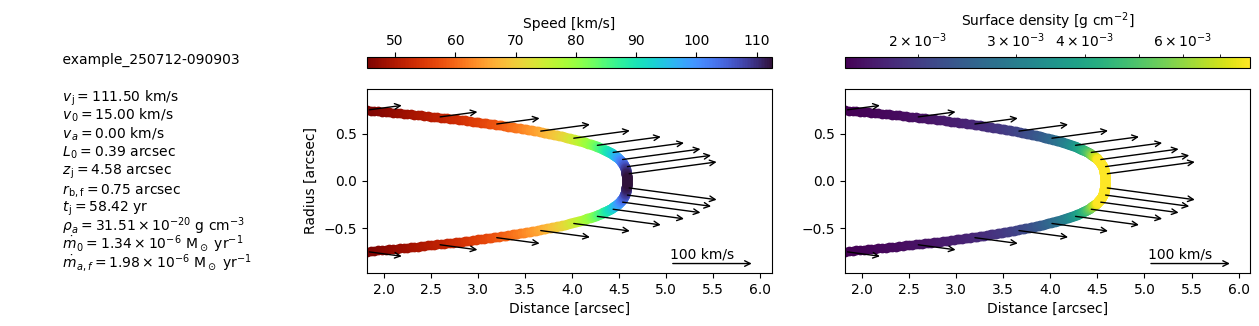

In [547]:
plt_model = BowshockModelPlot(
    bowshock_model,
    modelname=modelname,
#    v_arrow_ref=100,
#    figsize=(16,3),
#    textbox_widthratio=0.7,
 )
plt_model.plot()
plt_model.savefig()

In [380]:
plt_model.minsurfdens_plot

np.float64(0.0008758504189793451)

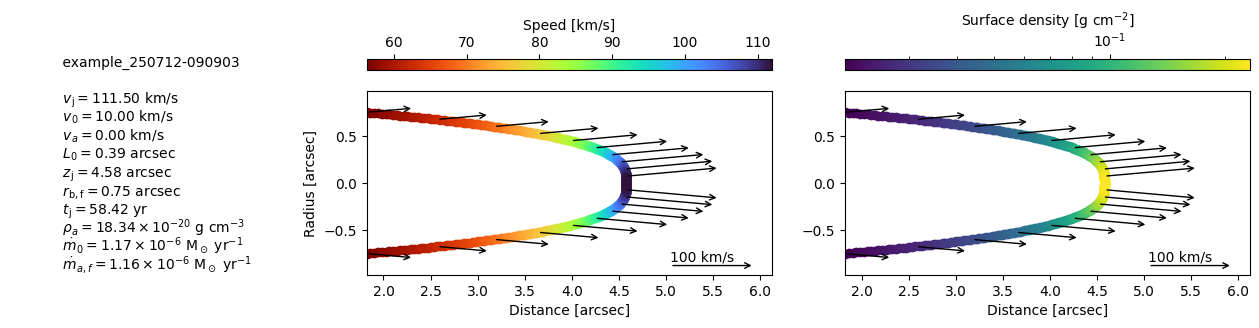

In [530]:
plt_model = bowshock_model.plotmodel(
    modelname=modelname,
#    v_arrow_ref=100,
#    figsize=(16,3),
#    textbox_widthratio=0.7,
 )
plt_model.plot()
plt_model.savefig()

In [28]:
plt_model.minsurfdens

np.float64(0.3321311800898754)

In [29]:
plt_model.maxsurfdens

np.float64(0.0316555052781707)

In [30]:
ObsModel?

Init signature: ObsModel(model, i, vsys, nzs=200, **kwargs)
Docstring:     
Computes the projected morphology and kinematics of a NarrowJet model

Parameters:
-----------
model : class instance
    instance of NarrowJet model to get the attributes
i : float
    Inclination angle between the bowshock axis and the line-of-sight
    [radians] 
vsys : float
    Systemic velocity of the source [km/s]
nzs : optional, int
    Number of points used to compute the model solutions
File:           ~/py_envs/bowpy/lib/python3.10/site-packages/bowshockpy/models.py
Type:           type
Subclasses:     Bowshock2D, BowshockCube

In [594]:
bowshock_obs = ObsModel(bowshock_model, i=93*np.pi/180, vsys=10, nzs=500)

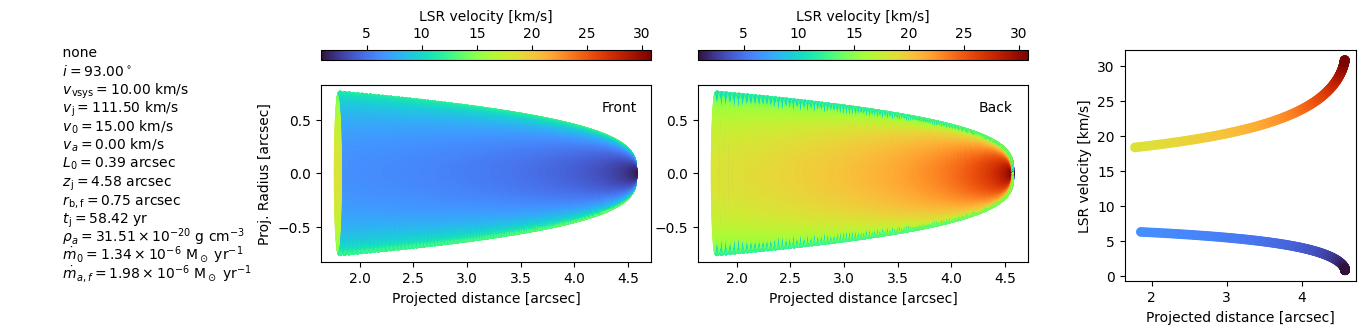

In [595]:
plt_obsmodel = BowshockObsModelPlot(
    bowshock_obs,
    figsize=(18, 3),
    maxpointsize=5,
    minpointsize=0.1,
    )
plt_obsmodel.plot()

In [569]:

class BowshockObsModelPlot():
    """
    Figure including the main parameters of the bowshock model, its projected
    morphology, kinematics, and a PV diagram along the symmetry axis with the
    distribution of the surface density in color code.
    
    Parameters:
    -----------
    bsm : `~bowshockpy.models.NarrowJet` class instance
        Instance of the model to plot
    modelname : optional, str
        Name of the model to include in the plot
    nzs : optional, int
        Number of points used to compute the model solutions
    figsize: optional, tuple
        Tuple passed to `matplotib.pyplot.figure` to define the dimensions of
        the figure
    linespacing : optional, float
        Spacing between the text lines
    textbox_widthratio : optional, float
        Width ratio of the text ax to pass to GridSpec
    cmap : optional, str
        Colormap label
    minpointsize : optional, float
        Minsize of the points to plot
    maxpointsize : optional, float
        Minsize of the points to plot


    Attributes:
    -----------
    nzs : int
        Number of points used to compute the model solutions
    zs : numpy.ndarray
        Array of the z-coordinates of the model.
    dzs : numpy.ndarray
        Increment of z-coordinates between the points.
    Rs : numpy.ndarray
        Array with the radii of the model at each z-coordinate [km].
    thetas : numpy.ndarray
        Array of the polar angle of the position vector at each point of the
        model [radians].
    vs : numpy.ndarray
        Array of the total velocity for each point of the model [km/s].
    vrs : numpy.ndarray
        Array of the radial component of the velocity at each point of the model
        [km/s].
    vzs : numpy.ndarray
        Array of the z-coordinate component of the velocity at each point of the
        model [km/s].
    surfdenss : numpy.ndarray 
        Array of the surfance density of the shell at each z-coordinate [Msun
        km-2]
    surfdenss_gcm2 : numpy.ndarray
        Array of the surfance density of the shell at each z-coordinate [g cm-2]
    axs : dict
        Dictionary of matplotlib.axes.Axes in the figure
    cbaxs : dict
        Dictionary of matplotlib.axes.Axes of the colorbars in the figure
    """

    def __init__(
            self, bsmobs, modelname="none",
            nzs=200,
            figsize=(16,3), 
            linespacing=0.08,
            textbox_widthratio=0.8,
            cmap="turbo",
            minpointsize=0.1,
            maxpointsize=5,
            ):
        self.mo = bsmobs
        self.modelname = modelname
        self.nzs = nzs
        self.nrs = nzs
        self.figsize = figsize
        self.linespacing = linespacing
        self.textbox_widthratio = textbox_widthratio

        self.zs = np.array([])
        self.dzs = np.array([])
        self.Rs = np.array([])

        self.vrs = np.array([])
        self.vzs = np.array([])
        self.vs = np.array([])
        self.thetas = np.array([])
        self.Rs_arcsec = np.array([])
        self.zs_arcsec = np.array([])

        self.surfdenss = np.array([])
        self.surfdenss_gcm2 = np.array([])

        self.xps_phi90 = np.array([])
        self.xps_phi0 = np.array([])
        self.xps_phi180 = np.array([])
        self.vloss_phi0 = np.array([])
        self.vloss_phi90 = np.array([])
        self.vloss_phi180 = np.array([])
        self.xps_phi0_arcsec = np.array([])
        self.xps_phi90_arcsec = np.array([])
        self.xps_phi180_arcsec = np.array([])
        self.maxvlos = None
        self.minvlos = None

        self.axs = {}
        self.cbaxs = {}
        self.cmap = cmap
        self.minpointsize = minpointsize
        self.maxpointsize = maxpointsize
        self.minsurfdens_plot = None 
        self.maxsurfdens_plot = None 

        self._calc_solutions()
        # self._create_axes()
        # self.plot()

    def _calc_solutions(self):
        # self.zsextended = self.zb_r(
        #     np.linspace(self.rbf, self.rj, self.nzs)
        # )
        # self.nrs = self.nzs
        self.rs = np.linspace(self.mo.rbf, 0, self.nrs)
        self.dr = self.rs[0] - self.rs[1]
        self.zs = self.mo.zb_r(self.rs)
        self.dzs = self.mo.dz_func(self.mo.zb_r(self.rs), self.dr)

        self.vs = np.array([self.mo.vtot(zb) for zb in self.zs])
        self.Rs = np.array([self.mo.rb(zb) for zb in self.zs])
        self.vrs = np.array([self.mo.vr(zb) for zb in self.zs])
        self.vzs = np.array([self.mo.vz(zb) for zb in self.zs])
        self.vs = np.array([np.sqrt(vrr**2+vzz**2) for vrr, vzz in zip(self.vrs, self.vzs)])
        self.maxvs = np.max(self.vs)
        self.minvs = np.min(self.vs)
        self.thetas = np.array([np.arctan(self.Rs[i] / z)
                       for i, z in enumerate(self.zs)])

        self.Rs_arcsec = self.mo.km2arcsec(self.Rs)
        self.zs_arcsec = self.mo.km2arcsec(self.zs)
 
        self.surfdenss = np.array([self.mo.surfdens(zb) for zb in self.zs])
        self.surfdenss_gcm2 = self.mo.solMasskm2togcm2(self.surfdenss)

        self.xps_phi90 = np.array([self.mo.xp(zb,phi=np.pi/2) for zb in self.zs])
        self.xps_phi0 = np.array([self.mo.xp(zb,phi=0) for zb in self.zs])
        self.xps_phi180 = np.array([self.mo.xp(zb,phi=np.pi) for zb in self.zs])
        self.vloss_phi0 = -np.array([self.mo.vzp(zb,phi=0) for zb in self.zs])
        self.vloss_phi90 = -np.array([self.mo.vzp(zb,phi=np.pi/2) for zb in self.zs])
        self.vloss_phi180 = -np.array([self.mo.vzp(zb,phi=np.pi) for zb in self.zs])
        self.maxvlos = np.max([self.vloss_phi0, self.vloss_phi180])
        self.minvlos = np.min([self.vloss_phi0, self.vloss_phi180])

        self.xps_phi0_arcsec = self.mo.km2arcsec(self.xps_phi0)
        self.xps_phi90_arcsec = self.mo.km2arcsec(self.xps_phi90)
        self.xps_phi180_arcsec = self.mo.km2arcsec(self.xps_phi180)

        phi_0 = -np.pi/2 
        phi_f = +np.pi*3/2
        # phi_0 =  np.pi*2#np.pi/2
        # phi_f = np.pi*2 + 3/2*np.pi
        phis = 500
        self.phis = np.linspace(phi_0, phi_f, phis)[:-1]

        self.xp_zs_phis = np.array([
            [self.mo.xp(zb, phi)
             for zb in self.zs]
            for phi in self.phis]
        )
        self.yp_zs_phis = np.array([
            [self.mo.yp(zb, phi)
             for zb in self.zs]
            for phi in self.phis]
        )
        self.vlos_zs_phis = np.array([
            [-self.mo.vzp(zb, phi)
             for zb in self.zs]
            for phi in self.phis]
        )

    def _create_axes(self):
        nrow = 1
        ncol = 4
        wspace = 0.15
        hspace = 0.4
        width_ratios = [self.textbox_widthratio, 1, 1, 1]
        height_ratios = [1] * nrow

        self.fig_model = plt.figure(figsize=self.figsize)
        gs = GridSpec(
            nrow, ncol,
            height_ratios=height_ratios,
            width_ratios=width_ratios,
            hspace=hspace, wspace=wspace
        )
        gss = {}
        gss[0] = gs[0, 1].subgridspec(
            2, 1,
            height_ratios=[0.05, 1],
            width_ratios=[1],
            hspace=0.05,
        )
        gss[1] = gs[0, 2].subgridspec(
            2, 1,
            height_ratios=[0.05, 1],
            width_ratios=[1],
            hspace=0.05,
        )
        gss[2] = gs[0, 3].subgridspec(
            2, 1,
            height_ratios=[0.05, 1],
            width_ratios=[1],
            hspace=0.05,
        )
        # gss[2] = gs[1, 1].subgridspec(
        #     2, 1,
        #     height_ratios=[0.05, 1],
        #     width_ratios=[1],
        #     hspace=0.05,
        # )

        self.axs["text"] = plt.subplot(gs[:, 0])
        self.axs[0] = plt.subplot(gss[0][1, 0])
        self.cbaxs[0] = plt.subplot(gss[0][0, 0])
        self.axs[1] = plt.subplot(gss[1][1, 0])
        self.cbaxs[1] = plt.subplot(gss[1][0, 0])
        self.axs[2] = plt.subplot(gss[2][:, 0])
        # self.cbaxs[2] = plt.subplot(gss[2][0, 0])
        self.axs["text"].set_axis_off()

    def plot(self):
        """
        Plots the 2D bowshock model
        """
        self._create_axes()
        showtext = \
            fr"""
            {self.modelname}
            $i = {{{self.mo.i*180/np.pi:.2f}}}^\circ$
            $v_\mathrm{{vsys}} = {{{self.mo.vsys:.2f}}}$ km/s
            $v_\mathrm{{j}} = {{{self.mo.vj:.2f}}}$ km/s
            $v_0 = {{{self.mo.v0:.2f}}}$ km/s
            $v_a = {{{self.mo.va:.2f}}}$ km/s
            $L_0 = {{{self.mo.L0_arcsec:.2f}}}$ arcsec
            $z_\mathrm{{j}} = {{{self.mo.zj_arcsec:.2f}}}$ arcsec
            $r_\mathrm{{b,f}} = {{{self.mo.rbf_arcsec:.2f}}}$ arcsec
            $t_\mathrm{{j}} = {{{self.mo.tj_yr:.2f}}}$ yr
            $\rho_a = {{{self.mo.rhoa_gcm3*10**20:.2f}}}\times 10^{{-20}}$ g cm$^{{-3}}$
            $\dot{{m}}_0 = {{{self.mo.mp0_solmassyr*10**6:.2f}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
            $\dot{{m}}_{{a,f}} = {{{self.mo.mpamb_f_solmassyr*10**6:.2f}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
            """

        self.axs["text"].set_axis_off()
        for n, line in enumerate(showtext.split("\n")):
             self.axs["text"].text(0, 1.05-self.linespacing*n, line, fontsize=10,
                              transform=self.axs["text"].transAxes)

        
        """
        Projected shell Morph. and Kin.
        """
        
        # controls the plotting order of the points 
        op = 1 if self.mo.i <= np.pi/2 else -1
        norm = colors.Normalize(
                    vmax=self.maxvlos + self.mo.vsys,
                    vmin=self.minvlos + self.mo.vsys,
                )
 
        range_point_sizes = np.linspace(
            self.maxpointsize,
            self.minpointsize,
            len(self.vlos_zs_phis.T)
            )[::op]
        point_sizes = [[i]*len(plt_obsmodel.vlos_zs_phis) for i in range_point_sizes]
        self.axs[0].scatter(
            self.mo.km2arcsec(self.xp_zs_phis.T[::op]),
            self.mo.km2arcsec(self.yp_zs_phis.T[::op]),
            c=self.vlos_zs_phis.T[::op] + self.mo.vsys,
            cmap=self.cmap,
            vmax=self.maxvlos + self.mo.vsys,
            vmin=self.minvlos + self.mo.vsys,
            s=point_sizes,
        )
        self.axs[0].set_aspect("equal")
        self.axs[0].text(0.85, 0.85, "Front", transform=self.axs[0].transAxes)
        self.axs[0].set_xlabel("Projected distance [arcsec]")
        self.axs[0].set_ylabel("Proj. Radius [arcsec]")

        cbar = plt.colorbar(
               cm.ScalarMappable(
                   norm=norm,
                   cmap=self.cmap,
               ),
               cax=self.cbaxs[0],
               orientation="horizontal",
        )

        self.cbaxs[0].tick_params(
            which="both",
            bottom=False, labelbottom=False,
            top=True, labeltop=True
        )
        self.cbaxs[0].set_xlabel(r"LSR velocity [km/s]", )
        self.cbaxs[0].xaxis.set_label_position('top')

        range_point_sizes = np.linspace(
            self.maxpointsize,
            self.minpointsize,
            len(self.vlos_zs_phis.T)
            )[::-op]
        point_sizes = [[i]*len(plt_obsmodel.vlos_zs_phis) for i in range_point_sizes]
        self.axs[1].scatter(
            self.mo.km2arcsec(self.xp_zs_phis.T[::-op]),
            self.mo.km2arcsec(self.yp_zs_phis.T[::-op]),
            c=self.vlos_zs_phis.T[::-op] + self.mo.vsys,
            cmap=self.cmap,
            vmax=self.maxvlos + self.mo.vsys,
            vmin=self.minvlos + self.mo.vsys,
            s=point_sizes,
        )
        self.axs[1].set_aspect("equal")
        self.axs[1].text(0.85, 0.85, "Back", transform=self.axs[1].transAxes)

        cbar = plt.colorbar(
               cm.ScalarMappable(
                   norm=norm,
                   cmap=self.cmap,
               ),
               cax=self.cbaxs[1],
               orientation="horizontal",
        )
        self.axs[1].set_xlabel("Projected distance [arcsec]")

        self.cbaxs[1].tick_params(
            which="both",
            bottom=False, labelbottom=False,
            top=True, labeltop=True
        )
        self.cbaxs[1].set_xlabel(r"LSR velocity [km/s]", )
        self.cbaxs[1].xaxis.set_label_position('top')


        """
        PV diagram: projected velocity
        """
        self.axs[2].scatter(
            self.xps_phi180_arcsec,
            self.vloss_phi180 + self.mo.vsys,
            marker="o",
            c=self.vloss_phi180 + self.mo.vsys,
            vmax=self.maxvlos + self.mo.vsys,
            vmin=self.minvlos + self.mo.vsys,
            cmap=self.cmap,
        )
        self.axs[2].scatter(
            self.xps_phi0_arcsec,
            self.vloss_phi0 + self.mo.vsys,
            marker="o",
            c=self.vloss_phi0 + self.mo.vsys,
            vmax=self.maxvlos + self.mo.vsys,
            vmin=self.minvlos + self.mo.vsys,
            cmap=self.cmap
        )
        allvelsarray = np.array([
            self.vloss_phi0[:-1] + self.mo.vsys,
            self.vloss_phi180[:-1] + self.mo.vsys]).ravel()
        argmaxvelpv = np.argmax(np.abs(allvelsarray))
        if allvelsarray[argmaxvelpv]<0:
            self.axs[2].invert_yaxis()
        else:
            pass

        self.axs[2].set_box_aspect(1) 
        self.axs[2].set_xlabel("Projected distance [arcsec]")
        self.axs[2].set_ylabel("LSR velocity [km/s]")

        # cbar = plt.colorbar(
        #        cm.ScalarMappable(
        #            norm=norm,
        #            cmap=self.cmap,
        #        ),
        #        cax=self.cbaxs[2],
        #        orientation="horizontal",
        # )

        # self.cbaxs[2].tick_params(
        #     which="both",
        #     bottom=False, labelbottom=False,
        #     top=True, labeltop=True
        # )
        # self.cbaxs[1].set_xlabel(r"Surface density [g cm$^{-2}$]", )
        # self.cbaxs[2].set_xlabel(r"LSR velocity [km/s]", )
        # self.cbaxs[2].xaxis.set_label_position('top')

         
    def savefig(self, figname=None):
        """
        Saves the plot of the bowhsock model.       

        Parameters
        ----------
        figname : optional, str
            Full path name of the figure. If None, the the full path name will
            be models/{self.modelname}/bowshock_plot.pdf. If the folder tree does not exist, it will be created. 
        """
        if figname is None:
            ut.make_folder(f"models/{self.modelname}")
            figname = f"models/{self.modelname}/bowshock_plot.pdf"
        self.fig_model.savefig(f"{figname}", bbox_inches="tight")





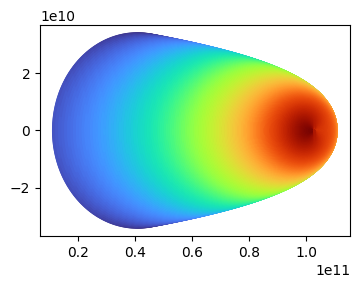

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = plt.subplot()

ax.scatter(
    plt_obsmodel.xp_zs_phis.T,
    plt_obsmodel.yp_zs_phis.T,
    c=plt_obsmodel.vzp_zs_phis.T,
    cmap="turbo_r",
    s=[
        [i]*len(plt_obsmodel.vzp_zs_phis)
        for i in np.linspace(5, 0.1, len(plt_obsmodel.vzp_zs_phis.T))
    ],
    vmax=
)

ax.set_aspect("equal")

In [ ]:
        # """
        # PV diagram : surface density
        # """
        # self.minsurfdens_plot = np.percentile(self.surfdenss_gcm2[:-1], 0) 
        # self.maxsurfdens_plot = np.percentile(self.surfdenss_gcm2[:-1], 70)
        # norm = colors.LogNorm(
        #             vmax=self.maxsurfdens_plot,
        #             vmin=self.minsurfdens_plot,
        # #           linthresh=self.maxsurfdens*0.99,
        #             )
        # cmap = "viridis"
        # # we skip the point at the tip, there is a discontinuity and the surface
        # # density is 0
        # for i in range(len(self.zs[:-1])):
        #     c = ut.get_color(
        #             [self.minsurfdens_plot, self.maxsurfdens_plot],
        #             self.surfdenss_gcm2[i],
        #             cmap,
        #             customnorm=norm,
        #     )
        #     self.axs[1].plot(
        #         self.xps_phi180_arcsec[i],
        #         self.vzps_phi180[i] + self.mo.vsys,
        #         marker="o",
        #         color=c
        #     )
        #     self.axs[1].plot(
        #         self.xps_phi0_arcsec[i],
        #         self.vzps_phi0[i] + self.mo.vsys,
        #         marker="o",
        #         color=c
        #     )
        # allvelsarray = np.array([
        #     self.vzps_phi0[:-1] + self.mo.vsys,
        #     self.vzps_phi180[:-1] + self.mo.vsys]).ravel()
        # argmaxvelpv = np.argmax(np.abs(allvelsarray))
        # if allvelsarray[argmaxvelpv]<0:
        #     self.axs[1].invert_yaxis()
        # else:
        #     pass
        # self.axs[1].set_xlabel("Projected distance [arcsec]")
        # self.axs[1].set_ylabel("LOS velocity [km/s]")

        # cbar = plt.colorbar(
        #        cm.ScalarMappable(
        #            norm=norm,
        #            cmap=cmap,
        #        ),
        #        cax=self.cbaxs[1],
        #        orientation="horizontal",
        # )

        # self.axs[1].set_box_aspect(1) 
        # self.cbaxs[1].tick_params(
        #     which="both",
        #     bottom=False, labelbottom=False,
        #     top=True, labeltop=True
        # )
        # self.cbaxs[1].set_xlabel(r"Surface density [g cm$^{-2}$]", )
        # self.cbaxs[1].xaxis.set_label_position('top')



In [17]:
bowshock_obs.nzs

200

In [15]:
i = 30. * np.pi / 180
vsys = 0.
distpc = 300.
nzs = 500

In [16]:
bsmobs = bs.ObsModel(
    bsm, i=i, vsys=vsys,
    distpc=distpc, nzs=nzs
    )

In [17]:
bs2D = bs.Bowshock2D(bsmobs)

In [18]:
bs.Bowshock2DPlots?

Init signature: bs.Bowshock2DPlots(obsmod, modelname, **kwargs)
Docstring:     
Computes a 2D plot of a bowshock model

Parameters:
-----------
obsmod : class instance
    Instance of ObsModel to plot
modelname : str
    Name of the model
File:           ~/py_envs/bowpy/lib/python3.10/site-packages/bowshockpy/bsmodels.py
Type:           type
Subclasses:     

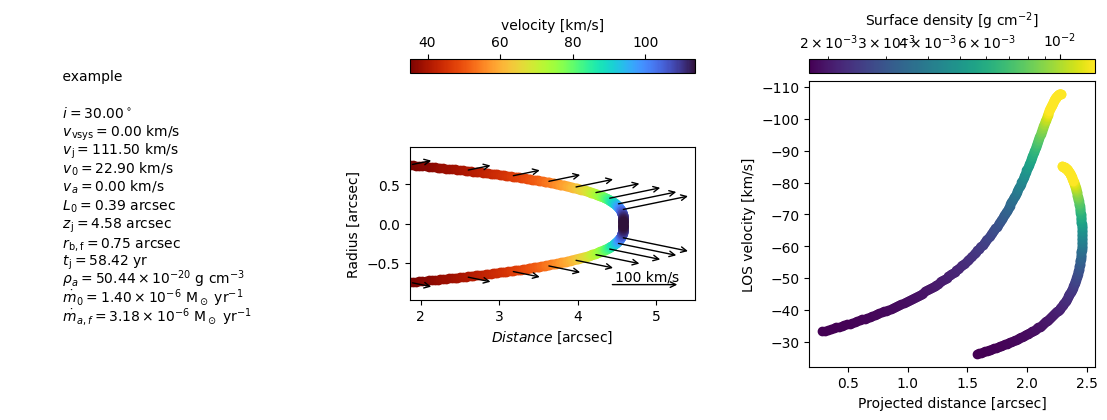

In [19]:
bs2Dplot = bs.Bowshock2DPlots(bsmobs, modelname="example")
bs2Dplot.plot()

In [20]:
bs2Dplot.savefig(f"2D.pdf")

In [21]:
bs.BowshockCube?

Init signature:
bs.BowshockCube(
    obsmodel,
    nphis,
    vch0,
    vchf,
    xpmax,
    pa=0,
    nc=50,
    nxs=200,
    nys=200,
    refpix=[0, 0],
    CIC=True,
    vt='2xchannel',
    tolfactor_vt=None,
    verbose=True,
    **kwargs,
)
Docstring:     
Computes the spectral cube of the bowshock model

Parameters:
-----------
obsmodel : class instance
    Instance of ObsModel
nphis : int
    Number of azimuthal angle phi to calculate the bowshock solution
vch0 : float
    Central velocity of the first channel map [km/s]
vchf : float
    Central velocity of the last channel map [km/s]
xpmax : float
    Physical size of the channel maps along the x axis [arcsec]
pa : optional, float
    Position angle [radians]
nc : optional, int
    Number of spectral channel maps
nxs : optional, int
    Number of pixels in the right ascension axis.
nys : optional, int
    Number of pixels in the declination axis. 
refpix : optional, list | None
    Pixel coordinates (zero-based) of the source, 

In [22]:
bsc = bs.BowshockCube(
    bsmobs,
    nphis=500,
    nc=50,
    vch0=-10, 
    vchf=-120,
    xpmax=5,    
    nxs=50,
    nys=50, 
    refpix=[25, 10], 
    CIC=True,
    vt="2xchannel",
    tolfactor_vt=5,
    verbose=True,
    )

In [23]:
bsc.makecube()


Computing masses...
  0──────────────────────────────────────────────────)100.0% | 68/61s


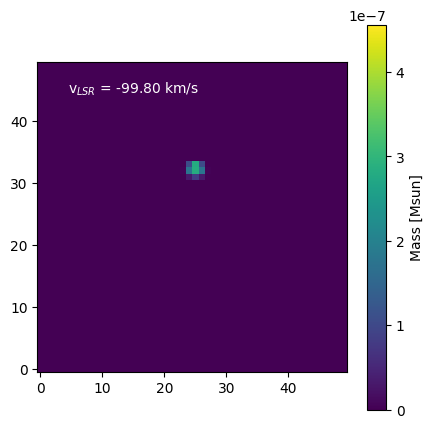

In [24]:
# TODO: add this function in BowshockCube as a method
chan = -10
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    bsc.cube[chan],
    origin="lower",
    vmax=np.max(bsc.cube),
    vmin=np.min(bsc.cube)
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bsc.velchans[chan]+bsc.vsys:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

In [37]:
100 * np.abs(bsc.mass - np.sum(bsc.cube)) / bsc.mass

np.float64(1.844528622739785)

In [38]:
np.sum(bsc.cube)

np.float64(0.0002267391388814711)

In [39]:
bsc.mass

0.000231

In [40]:
np.isclose(bsc.mass, np.sum(bsc.cube))

np.False_

In [41]:
100 * np.abs(bsc.mass - np.sum(bsc.cube)) / bsc.mass

np.float64(1.844528622739785)

In [42]:
bs.CubeProcessing?

Init signature:
bs.CubeProcessing(
    bscube,
    J='3-2',
    XCO=8.5e-05,
    meanmass=<Quantity 4.64884609e-24 g>,
    Tex=<Quantity 100. K>,
    Tbg=<Quantity 2.7 K>,
    coordcube='offset',
    ra_source_deg=None,
    dec_source_deg=None,
    bmin=None,
    bmaj=None,
    pabeam=None,
    papv=None,
    parot=None,
    sigma_beforeconv=None,
    maxcube2noise=None,
    **kwargs,
)
Docstring:     
Process a BowshockCube instance

Parameters:
-----------
File:           ~/py_envs/bowpy/lib/python3.10/site-packages/bowshockpy/bsmodels.py
Type:           type
Subclasses:     

In [25]:
bscs = bs.CubeProcessing(
    bsc,
    J="3-2",
    XCO=8.5*10**(-5),
    meanmass=2.8 / (6.023*10**23) * u.g,
    Tex=100*u.K,
    Tbg=2.7*u.K,
    coordcube="offset",
    ra_source_deg=None,
    dec_source_deg=None,
    bmaj = 0.420,
    bmin = 0.287,
    pabeam = -2.2,
    papv=bsc.pa,
    parot=0,
    sigma_beforeconv=0.05,
    maxcube2noise=0.07,

)

In [34]:
bscs.convolve()


Convolving m_c... 

m_c has been convolved with a gaussian kernel with a size of [2.87, 4.20] pix and with a PA of -2.20deg



In [36]:
bscs.savecube("m")

models/example/fits/m.fits saved


In [39]:
type(bscs.hdrs["m"])

astropy.io.fits.header.Header

In [41]:
type(bscs.beamarea_sr)

astropy.units.quantity.Quantity

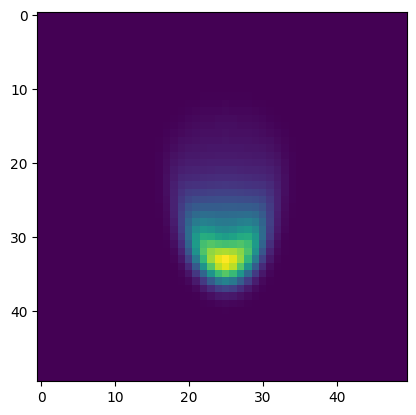

In [52]:
plt.imshow(bscs.cubes["m_c"][5])

In [54]:
outcubes = {
    "intensity": ["add_noise", "convolve", "moments_and_pv"],
    "opacity": [],
    "CO_column_density": [],
    "mass": [],
    }

bscs.calc(outcubes)


Computing column densities...
CO column densities has been calculated


Computing opacities...
Opacities has been calculated


Computing intensities...
Intensities has been calculated


Adding noise to I_n...
Noise added to I_n


Convolving I_nc... 

I_nc has been convolved with a gaussian kernel with a size of [2.87, 4.20] pix and with a PA of -2.20deg


The rms of the convolved image is 0.010516 Jy/beam



In [43]:

mom1 = bscs.mom1(
            "m",
            chan_range=[0, bscs.nc],
            save=True,
        )

models/example/fits/m_mom1.fits saved


models/example/fits/m_c_mom1.fits saved


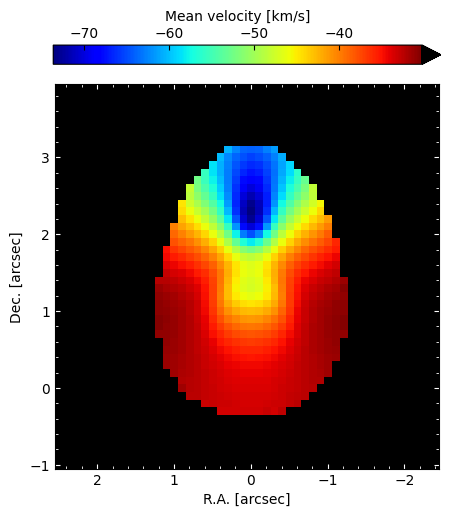

In [50]:
ck = "m_c"
mom1 = bscs.mom1(
            ck,
            chan_range=[0, bscs.nc],
            save=True,
        )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

ax = bscs.plotmom1(
    mom1,
    extent=extent,
    interpolation=None,
    cbarlabel="Mean velocity [km/s]",
    return_velcmap=True,
    )

In [51]:
type(ax)

matplotlib.colors.ListedColormap

In [ ]:
bscs.mom1plot(
            "m",
            chan_range=[0, bscs.nc],
            save=True,
        )

In [44]:
mom1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(50, 50))

In [ ]:
bsmobs = bs.ObsModel(ps, psobs)

pscube = {
    "nphis": 500,   
    "nc": 50,
    "vt": "2xchannel",
    "vch0": 0, # center value
    "vchf": -150, # center value   
    "nxs": 35 ,
    "nys": 35 , 
    "refpix": [5, 15], 
    "xpmax": 5,    
    "pa": 160,
    "bmaj": 0.420,
    "bmin": 0.287,
    "pabeam": -2.2,
    "CIC": True,
    "tolfactor_vt":2,
    "maxcube2noise": 10,
    "verbose": True,
}
pscube["chanwidth"] = (pscube["vchf"] - pscube["vch0"]) / (pscube["nc"]-1)
pscube["abschanwidth"] = np.abs(pscube["chanwidth"])
pscube["vt"] = pscube["vt"] if type(pscube["vt"])!=str \
      else float(pscube["vt"].split("x")[0])*pscube["chanwidth"]
pscube["arcsecpix"] = pscube["xpmax"] / float(pscube["nxs"])
pscube["x_FWHM"] = pscube["bmin"] / pscube["arcsecpix"]
pscube["y_FWHM"] = pscube["bmaj"] / pscube["arcsecpix"]
pscube["beamarea"] = np.pi * pscube["y_FWHM"] * pscube["x_FWHM"] / (4 * np.log(2))
if pscube["refpix"] == None:
    if pscube["nxs"]%2 == 0:
        xref = pscube["nxs"] / 2
    else:
        xref = (pscube["nxs"]-1) / 2
    if pscube["nys"]%2 == 0:
        yref = pscube["nys"] / 2
    else:
        yref = (pscube["nys"]-1) / 2
    pscube["refpix"] = [xref, yref]

vla4b_skycoords = SkyCoord(ra='03h29m3.7684s', dec='31d16m3.776s', frame='icrs')
ra_source_deg = vla4b_skycoords.ra.deg
dec_source_deg = vla4b_skycoords.dec.deg
mpars = {
    "muH2": 2.8, # Mean molecular mass per H molecule
    "XCO": 8.5*10**(-5),
    "Tex": 100*u.K,
    "Tbg": 2.7*u.K,
    "ra_source_deg": ra_source_deg,
    "dec_source_deg": dec_source_deg
}
mpars["meanmass"] = mpars["muH2"] / (6.023*10**23) * u.g



In [9]:
bsc = bs.BowshockCube(ps, psobs, pscube)
bsc.makecube()

bscs = bs.CubeProcessing(bsc, mpars)
bscs.calc(["m_src"])
#bscs.add_source()
#bscs.rotate()
# bscs.calc_NCO()
# bscs.calc_tau()
# bscs.calc_I()
# for ck in ["NCO", "tau", "I"]:
#     bscs.savecube(ck)



Computing masses...
  0──────────────────────────────────────────────────)100.0% | 84/95s

Adding source to m_s...
m_s has been added a source in pix [5.00, 15.00] pix


Rotatng m_sr...
m_sr has been rotated to a PA = 160 deg


Convolving m_src... 
m_src has been convolved with a gaussian kernel [2.01, 2.94] pix and a PA of -2.20deg



In [10]:
bscs.rotate(ck="m_sr", forpv=True)
bscs.rotate(ck="m_src", forpv=True)


Rotatng m_srR in order to compute the PV diagram...
m_srR has been rotated to a PA = 160 deg


Rotatng m_srcR in order to compute the PV diagram...
m_srcR has been rotated to a PA = 160 deg



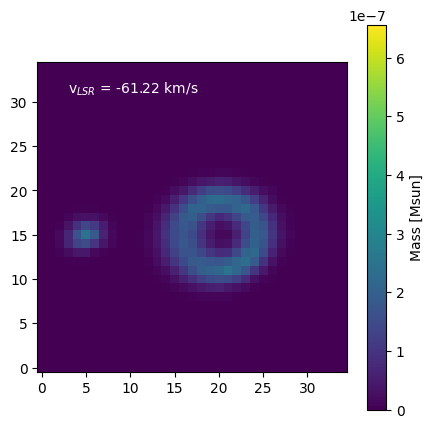

In [11]:
ck = "m_srcR"
chan = 20 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    bscs.cubes[ck][chan],
    origin="lower",
    vmax=np.max(bscs.cubes[ck]),
    vmin=np.min(bscs.cubes[ck])
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bscs.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

models/bs1_240724-124710/fits/m_srR_pv.fits saved


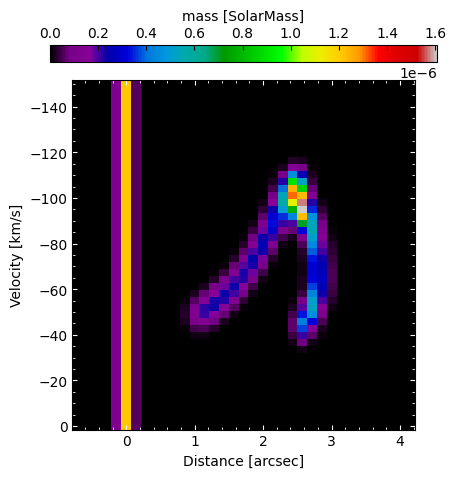

In [12]:
ck = "m_srR"
pvimage = bscs.pvalongz(
    ck, halfwidth=0, save=True,
    )

rangex = np.array([
    -0.5-bscs.refpixs[ck][0],
    bscs.nxs-0.5-bscs.refpixs[ck][0]
    ]) * bscs.arcsecpix

chan_vels = bscs.velchans
bscs.plotpv(
    pvimage,
    rangex=rangex,
    chan_vels=chan_vels,
    cbarlabel=bscs.getunitlabel(ck),
    interpolation=None,
    )

models/bs1_240724-124710/fits/m_sr_sumint.fits saved


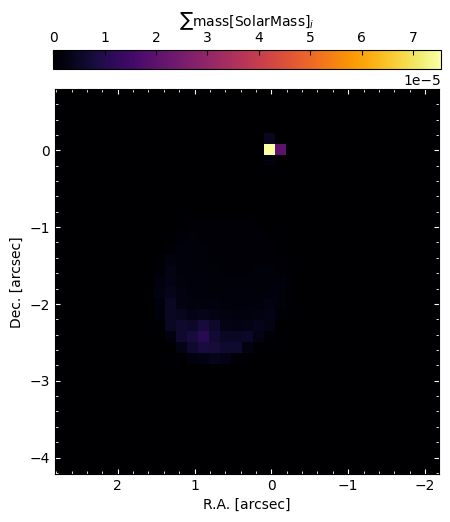

In [13]:
ck = "m_sr"

sumintimage = bscs.sumint(
    ck,
    chan_range=[0, bscs.nc],
    save=True,
    )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

bscs.plotsumint(
    sumintimage,
    extent=extent,
    interpolation=None,
    cbarlabel=bscs.getunitlabel(ck),
    )


models/bs1_240724-124710/fits/m_sr_mom0.fits saved


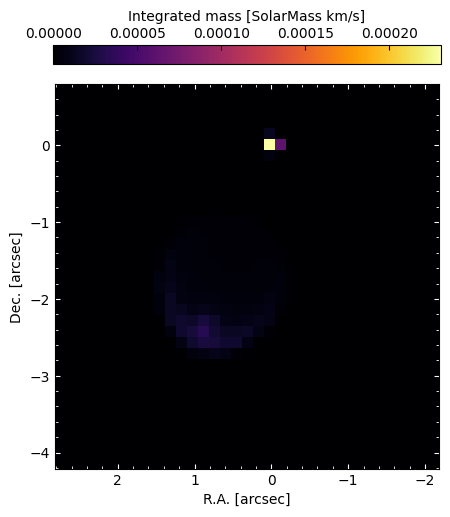

In [14]:
ck = "m_sr"

chan_vels = bscs.velchans
mom0 = bscs.mom0(
    ck,
    chan_range=[0, bscs.nc],
    save=True,
    )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

bscs.plotmom0(
    mom0,
    extent=extent,
    interpolation=None,
    cbarlabel="Integrated " + bscs.getunitlabel(ck).rstrip("]") + " km/s]"
    )


/mnt/hdd/L1448/bowshockpy/bowpy/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)


models/bs1_240724-124710/fits/m_sr_mom1.fits saved


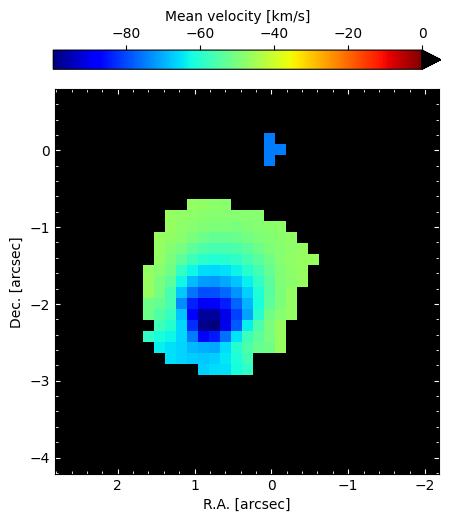

In [15]:
ck = "m_sr"

mom1 = bscs.mom1(
            ck,
            chan_range=[0, bscs.nc],
            save=True,
        )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

bscs.plotmom1(
    mom1,
    extent=extent,
    interpolation=None,
    cbarlabel="Mean velocity [km/s]"
    )

/mnt/hdd/L1448/bowshockpy/bowpy/moments.py:33: RuntimeWarning: invalid value encountered in divide
  disp = np.sqrt(sumIixvi(cube, chan_vels, chan_range, exp=2)


models/bs1_240724-124710/fits/m_sr_mom2.fits saved


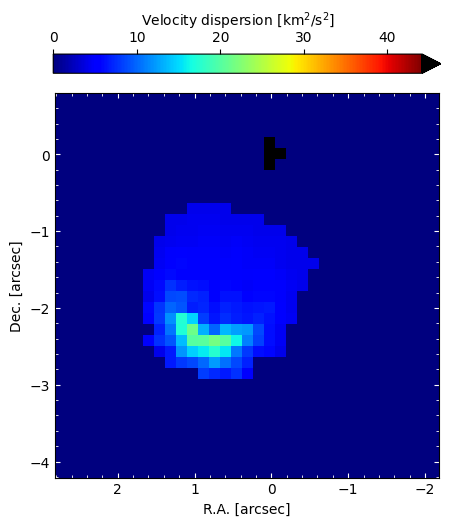

In [16]:
ck = "m_sr"

mom2 = bscs.mom2(
            ck,
            chan_range=[0, bscs.nc],
            save=True,
        )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

bscs.plotmom2(
    mom2,
    extent=extent,
    interpolation=None,
    cbarlabel="Velocity dispersion [km$^2$/s$^2$]"
    )

models/bs1_240724-124710/fits/m_sr_mom8.fits saved


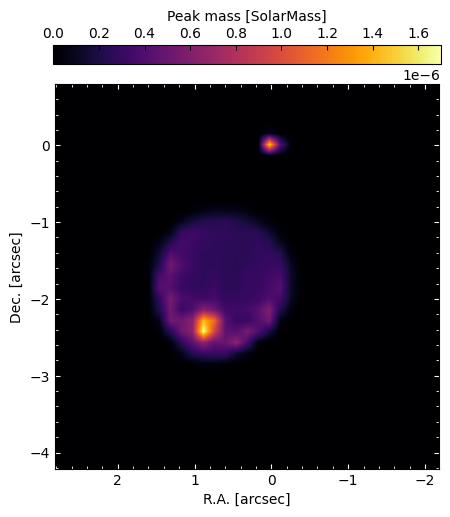

In [17]:
ck = "m_sr"

mom8 = bscs.mom8(
            ck,
            chan_range=[0, bscs.nc],
            save=True,
        )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

bscs.plotmom8(
    mom8,
    extent=extent,
    cbarlabel="Peak " + bscs.getunitlabel(ck)
    )



Computing moments and the PV-diagram along the jet axis

models/bs1_240724-124710/fits/m_sr_mom0.fits saved
models/bs1_240724-124710/fits/m_sr_mom1.fits saved
models/bs1_240724-124710/fits/m_sr_mom2.fits saved
models/bs1_240724-124710/fits/m_srR_pv.fits saved
models/bs1_240724-124710/fits/m_sr_mom8.fits saved


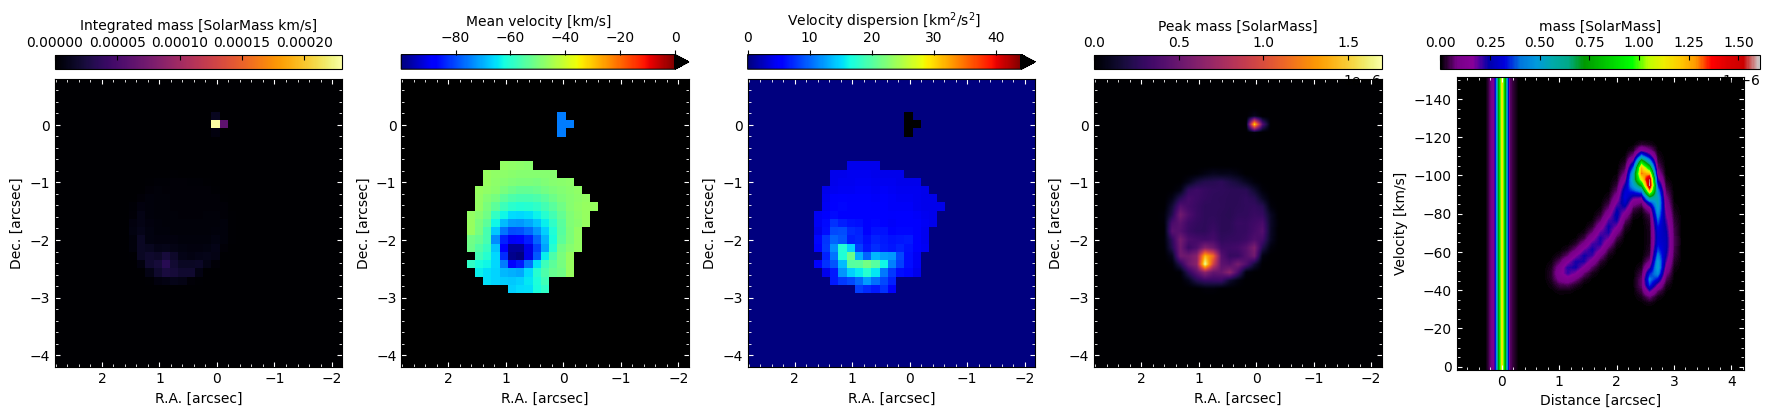

In [18]:
bscs.momentsandpv("m_sr", savefits=True, saveplot=True)

In [ ]:
axtext = 
fr"""
{p.modelname}
Number of bowshocks: {p.nbowshocks}
Tex = {p.Tex}
$i = {[{{p.i*180/np.pi:.2f}} for i in ]}^\circ$
$V_\mathrm{{jet}} = {{{p.vj:.2f}}}$ km/s
$V_0 = {{{p.v0:.2f}}}$ km/s
$V_w = {{{p.vw:.2f}}}$ km/s
$L_0 = {{{p.L0_arcsec:.2f}}}$ arcsec
$z_\mathrm{{jet}} = {{{p.zj_arcsec:.2f}}}$ arcsec
$r_\mathrm{{b,f}} = {{{p.rbf_arcsec:.2f}}}$ arcsec
$t_\mathrm{{jet}} = {{{p.tj_yr:.2f}}}$ yr
$\rho_w = {{{self.rhow_gcm3*10**20:.2f}}}\times 10^{{-20}}$ g cm$^{{-3}}$
$\dot{{m}}_0 = {{{self.mp0_solmassyr*10**6:.2f}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
$\dot{{m}}_{{w,f}} = {{{self.mpamb_f_solmassyr*10**6:.2f}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
"""


In [124]:
import importlib
bpf_str = input(
"""
Enter the name of the file where the parameters are defined (default: bowshock_params): 
"""
)
bpf_str = bpf_str if bpf_str!="" else "bowshock_params"
p = importlib.import_module(bpf_str.strip(".py"))
print(
f"""
Parameters read from {bpf_str}.py
"""
)


Parameters read from bowshock_params.py



In [75]:
def momentsandpv_params(bscs):
    mom1clipping=0
    mom2clipping=0
    verbose=True,
    mom0values={v: None for v in ["vmax", "vcenter", "vmin"]}
    mom1values={v: None for v in ["vmax", "vcenter", "vmin"]}
    mom2values={v: None for v in ["vmax", "vcenter", "vmin"]}
    mom8values={v: None for v in ["vmax", "vcenter", "vmin"]}
    pvvalues={v: None for v in ["vmax", "vcenter", "vmin"]}
    
    ckpv = ck + "R" 
    if ckpv not in self.cubes:
        self.rotate(ck, forpv=True)
    
    fig = plt.figure(figsize=(14,10))
    gs = GridSpec(
        2, 3,
        width_ratios=[1]*3, # + [0.85]*2,
        height_ratios=[1]*2,
        hspace=0.3,
        wspace=0.25,
    )
    axs = {}
    cbaxs = {}
    gss = {}
   
    ik = "text"
    axs[ik] = plt.subplot(gs[0,0])
    axs[ik].set_axis_off()
    
    ik = "mom0"
    gss[ik] = gs[0,1].subgridspec(
             2, 1,
             height_ratios=[0.05, 1],
             width_ratios=[1],
             hspace=0.05,
         )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])
    
    ik = "mom8"
    gss[ik] = gs[0,2].subgridspec(
             2, 1,
             height_ratios=[0.05, 1],
             width_ratios=[1],
             hspace=0.05,
         )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])
    
    ik = "pv"
    gss[ik] = gs[1,0].subgridspec(
             2, 1,
             height_ratios=[0.05, 1],
             width_ratios=[1],
             hspace=0.05,
         )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])
    
    
    ik = "mom1"
    gss[ik] = gs[1,1].subgridspec(
             2, 1,
             height_ratios=[0.05, 1],
             width_ratios=[1],
             hspace=0.05,
         )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])
    
    ik = "mom2"
    gss[ik] = gs[1,2].subgridspec(
             2, 1,
             height_ratios=[0.05, 1],
             width_ratios=[1],
             hspace=0.05,
         )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])
    
    ak = "text"
    # ies = [p.__getattribute__(f"i_{i+1}")*180/np.pi for i in range(p.nbowshocks)]
    # rjs = [p.__getattribute__(f"rj_{i+1}") for i in range(p.nbowshocks)]
    # L0s = [p.__getattribute__(f"L0_{i+1}") for i in range(p.nbowshocks)]
    # zjs = [p.__getattribute__(f"zj_{i+1}") for i in range(p.nbowshocks)]
    # vjs = [p.__getattribute__(f"vj_{i+1}") for i in range(p.nbowshocks)]
    # vws = [p.__getattribute__(f"vw_{i+1}") for i in range(p.nbowshocks)]
    # v0s = [p.__getattribute__(f"vw_{i+1}") for i in range(p.nbowshocks)]
    # rbf_obss = [p.__getattribute__(f"rbf_obs_{i+1}") for i in range(p.nbowshocks)]
    # masss = [p.__getattribute__(f"mass_{i+1}") for i in range(p.nbowshocks)]

    ies = [bsc.i*180/np.pi for bsc in bscs]
    Texs = [bsc.Tex for bsc in bscs]
    #rjs = [bsc.rj for bsc in bscs]
    L0s = [bsc.L0_arcsec for bsc in bscs]
    zjs = [bsc.zj_arcsec for bsc in bscs]
    vjs = [bsc.vj for bsc in bscs]
    vws = [bsc.vw for bsc in bscs]
    v0s = [bsc.v0 for bsc in bscs]
    rbfs = [bsc.rbf_arcsec for bsc in bscs]
    tjyrs = [bsc.tjyrs for bsc in bscs]
    # masss = [bsc.mass for bsc in bscs]
    rhows = [bsc.rhow_gcm3*10**20 for bsc in bscs]
    m0s = [bsc.mp0_solmassyr*10**6 for bsc in bscs]
    mwfs = [bsc.mpamb_f_solmassyr*10**6 for bsc in bscs]


    showtext = \
    f"""
    {p.modelname}
    Number of bowshocks: {len(bscs)}
    Tex = {ut.list2str([Texs])} K
    $i = {{{ut.list2str([ies])}}}^\circ$
    $V_\mathrm{{jet}} = {{{ut.list2str(vjs)}}}$ km/s
    $V_0 = {{{ut.list2str(v0s)}}}$ km/s
    $V_w = {{{ut.list2str(vws)}}}$ km/s
    $L_0 = {{{ut.list2str(L0s)}}}$ arcsec
    $z_\mathrm{{jet}} = {{{ut.list2str(zjs)}}}$ arcsec
    $r_\mathrm{{b,f}} = {{{ut.list2str(rbfs)}}}$ arcsec
    $t_\mathrm{{jet}} = {{{ut.list2str(tjyrs)}}}$ yr
    $\rho_w = {{{ut.list2str(rhows)}}}\times 10^{{-20}}$ g cm$^{{-3}}$
    $\dot{{m}}_0 = {{{ut.list2str(m0s)}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
    $\dot{{m}}_{{w,f}} = {{{ut.list2str(mwfs)}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
    """
    for n, line in enumerate(showtext.split("\n")):
        axs["text"].text(0, 0.99-0.07*n, line, fontsize=12,
                          transform=axs["text"].transAxes)
    
    ak = "mom0"
    mom0 = self.mom0(
        ck,
        chan_range=[0, self.nc],
        save=False,
        )
    extent = np.array([
        -(-0.5-self.refpixs[ck][0]),
        -(self.nxs-0.5-self.refpixs[ck][0]),
        (-0.5-self.refpixs[ck][1]),
        (self.nys-0.5-self.refpixs[ck][1]),
        ]) * self.arcsecpix
    self.plotmom0(
        mom0,
        extent=extent,
        interpolation=None,
        ax=axs[ak],
        cbax=cbaxs[ak],
        cbarlabel="Integrated " + self.getunitlabel(ck).rstrip("]") + " km/s]",
        **mom0values,
        )
    
    ak = "mom1"
    clipping = float(mom1clipping.split("x")[0]) * self.sigma_noises[ck] \
        if mom1clipping !=0 else 0
    mom1 = self.mom1(
                ck,
                chan_range=[0, self.nc], 
                save=False,
                clipping=clipping,
            )
    extent = np.array([
        -(-0.5-self.refpixs[ck][0]),
        -(self.nxs-0.5-self.refpixs[ck][0]),
        (-0.5-self.refpixs[ck][1]),
        (self.nys-0.5-self.refpixs[ck][1]),
        ]) * self.arcsecpix
    self.plotmom1(
        mom1,
        extent=extent,
        interpolation=None,
        ax=axs[ak],
        cbax=cbaxs[ak],
        cbarlabel="Mean velocity [km/s]",
        **mom1values,
        )
    
    ak = "mom2"
    clipping = float(mom2clipping.split("x")[0]) * self.sigma_noises[ck]\
        if mom1clipping !=0 else 0
    mom2 = self.mom2(
                ck,
                chan_range=[0, self.nc], 
                save=False,
                clipping=clipping,
            )
    extent = np.array([
        -(-0.5-self.refpixs[ck][0]),
        -(self.nxs-0.5-self.refpixs[ck][0]),
        (-0.5-self.refpixs[ck][1]),
        (self.nys-0.5-self.refpixs[ck][1]),
        ]) * self.arcsecpix
    self.plotmom2(
        mom2,
        extent=extent,
        interpolation=None,
        ax=axs[ak],
        cbax=cbaxs[ak],
        cbarlabel="Velocity dispersion [km$^2$/s$^2$]",
        **mom2values,
        )
    
    ak = "pv"
    pvimage = self.pvalongz(
        ckpv,
        halfwidth=0,
        save=False,
        )
    rangex = np.array([
        -0.5-self.refpixs[ckpv][0],
        self.nxs-0.5-self.refpixs[ckpv][0]
        ]) * self.arcsecpix
    chan_vels = self.velchans
    self.plotpv(
        pvimage,
        rangex=rangex,
        chan_vels=chan_vels,
        ax=axs[ak],
        cbax=cbaxs[ak],
        cbarlabel=self.getunitlabel(ckpv),
        **pvvalues,
        )
    #axs[ak].set_aspect(np.abs(np.diff(rangex))/np.abs((chan_vels[0]-chan_vels[-1])) * 0.9)
    
    ak = "mom8"
    mom8 = self.mom8(
                ck,
                chan_range=[0, self.nc],
                save=False,
            )
    extent = np.array([
        -(-0.5-self.refpixs[ck][0]),
        -(self.nxs-0.5-self.refpixs[ck][0]),
        (-0.5-self.refpixs[ck][1]),
        (self.nys-0.5-self.refpixs[ck][1]),
        ]) * self.arcsecpix
    self.plotmom8(
        mom8,
        extent=extent,
        ax=axs[ak],
        cbax=cbaxs[ak],
        cbarlabel="Peak " + self.getunitlabel(ck),
        **mom8values,
        )

In [120]:
def list2str(a, precision=2):
    return str([float(f'{i:.{precision}f}') for i in a])

In [121]:
a = [3.13, 2.12, 1.01, 0.32, 5.12]
showtext = \
fr"""
$a = {{{list2str(a)}}}$
b = 
"""


/mnt/hdd/L1448/bowshockpy/bowpy/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)
/mnt/hdd/L1448/bowshockpy/bowpy/moments.py:33: RuntimeWarning: invalid value encountered in divide
  disp = np.sqrt(sumIixvi(cube, chan_vels, chan_range, exp=2)


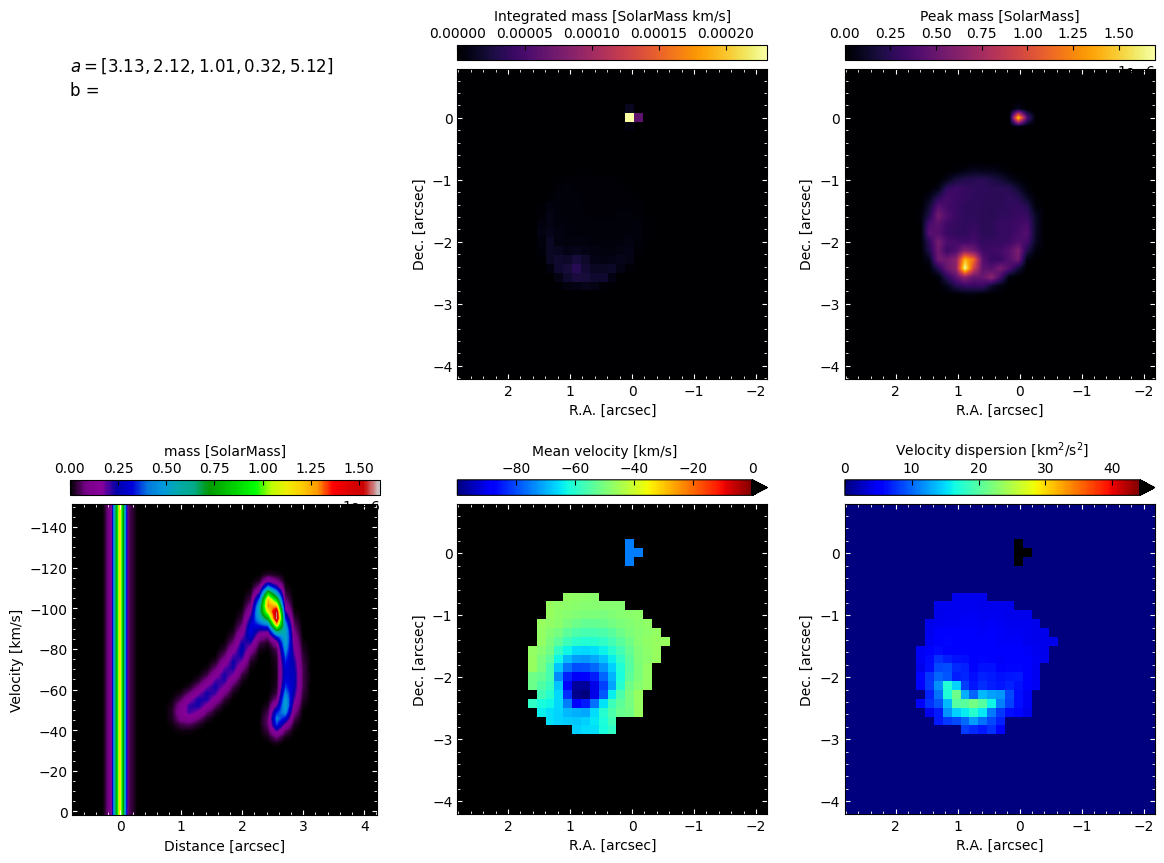

In [122]:
momentsandpv_params(showtext)

In [58]:
a = [1, 2, 3, 4]
b = [1, 2, 3, 4]
for i, (k,p) in enumerate(zip(a, b)):
    print(i, k, p)

0 1 1
1 2 2
2 3 3
3 4 4


In [66]:
print(
f"""
i = {[float(f'{i:.2f}') for i in a]}
b = {[float(f'{i:.2f}') for i in a]}
"""
)


i = [1.0, 2.0, 3.0, 4.0]
b = [1.0, 2.0, 3.0, 4.0]



In [56]:
np.array([a, b]).ravel()

array([1, 2, 3, 4, 1, 2, 3, 4])

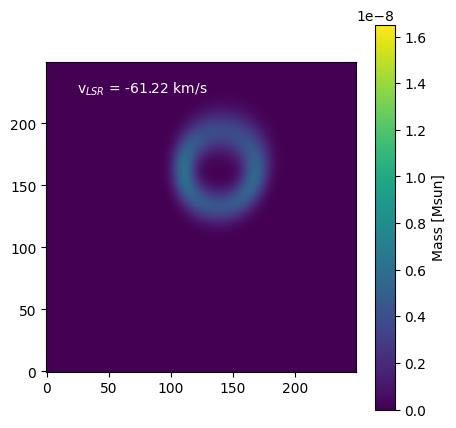

In [22]:
ck = "m_rc"
chan = 20 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    bscs.cubes[ck][chan],
    origin="lower",
    vmax=np.max(bscs.cubes[ck]),
    vmin=np.min(bscs.cubes[ck])
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bscs.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

/mnt/hdd/L1448/bowshockpy/bowpy/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)


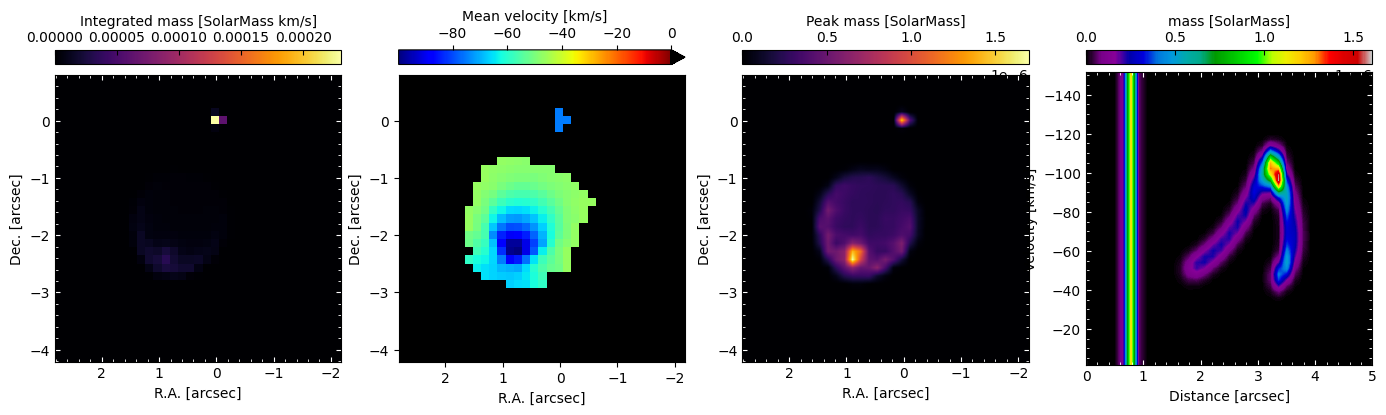

In [122]:
ck = "m_sr"
ckpv = ck + "R" 
fig = plt.figure(figsize=(17,9))
gs = GridSpec(
    2, 4,
    hspace=0.2,
    wspace=0.2,
)

axs = {}
cbaxs = {}
gss = {}

for i, ik in enumerate(["mom0", "mom1", "mom8", "pv"]):
    gss[ik] = gs[0,i].subgridspec(
        2, 1,
        height_ratios=[0.05, 1],
        width_ratios=[1],
        hspace=0.05,
    )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])

ak = "mom0"
mom0 = moments.mom0(
    bscs.cubes[ck],
    chan_vels=chan_vels,
    chan_range=[0, bscs.nc]
    )
extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix
plotmom0(
    mom0,
    extent=extent,
    interpolation=None,
    ax=axs[ak],
    cbax=cbaxs[ak],
    cbarlabel="Integrated " + bscs.getunitlabel(ck).rstrip("]") + " km/s]"
    )

ak = "mom1"
clipping = 0
cube_clipped = np.copy(bscs.cubes[ck])
cube_clipped[cube_clipped<clipping] = 0
mom1 = np.nan_to_num(
        moments.mom1(
            cube_clipped,
            chan_vels=chan_vels,
            chan_range=[0, bscs.nc], 
        )
    )
extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix
plotmom1(
    mom1,
    extent=extent,
    interpolation=None,
    ax=axs[ak],
    cbax=cbaxs[ak],
    cbarlabel="Mean velocity [km/s]"
    )

ak = "pv"
pvimage = moments.pv(
    bscs.cubes[ckpv],
    int(bscs.refpixs[ckpv][1]),
    halfwidth=0, axis=1
    )
rangex = np.array([0, bscs.arcsecpix*np.shape(pvimage)[1]])
chan_vels = bscs.velchans
plotpv(
    pvimage,
    rangex=rangex,
    chan_vels=chan_vels,
    ax=axs[ak],
    cbax=cbaxs[ak],
    cbarlabel=bscs.getunitlabel(ckpv),
    )

ak = "mom8"
clipping = 0
cube_clipped = np.copy(bscs.cubes[ck])
cube_clipped[cube_clipped<clipping] = 0
mom8 = np.nan_to_num(
        moments.mom8(
            cube_clipped,
            chan_range=[0, bscs.nc]
        )
    )
extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix
plotmom8(
    mom8,
    extent=extent,
    ax=axs[ak],
    cbax=cbaxs[ak],
    cbarlabel="Peak " + bscs.getunitlabel(ck)
    )

bsc.fig_model.savefig(f"models/{ps['modelname']}/2D.pdf")

KeyError: 'm_r'

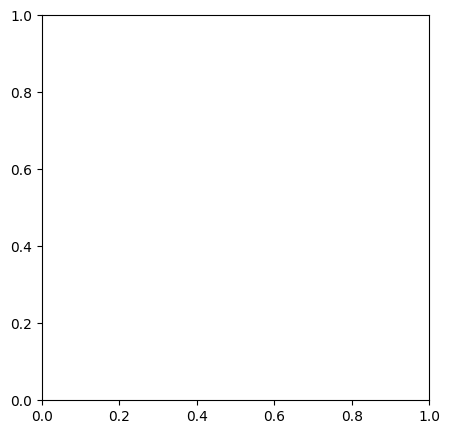

In [16]:
ck = "m_r"
chan = 20 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    bscs.cubes[ck][chan],
    origin="lower",
    vmax=np.max(bscs.cubes[ck]),
    vmin=np.min(bscs.cubes[ck])
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bscs.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

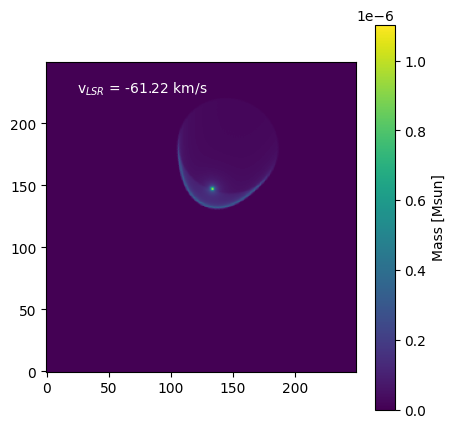

In [64]:
ck = "m_r"
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    np.sum(bscs.cubes[ck], axis=0),
    origin="lower",
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bscs.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")